<a href="https://colab.research.google.com/github/idrisinanoglu/DSA210-Project/blob/main/DSA_210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection – Weather Data

In this section, daily weather data for Istanbul is collected using the Meteostat API.
The dataset includes key meteorological variables such as average temperature,
precipitation, wind speed, and atmospheric pressure.

## Data Collection – Google Trends

Google Trends data is collected for analyzing public mood
and behavioral patterns. Due to the fact that Google Trends allows a maximum of five keywords per
request keywords are grouped by category and queried separately.

The keywords are organized into four conceptual categories:
- **Negative Mood:** terms related to psychological distress and negative emotions
- **Positive Mood:** terms reflecting positive emotional states
- **Negative Behavioral Indicators:** terms associated with fatigue, isolation, and sleep issues
- **Positive Behavioral Indicators:** terms related to physical activity and outdoor engagement

Weekly search interest data is retrieved for Türkiye between January 2022 and
December 2024.


In [1]:

!pip install meteostat pytrends

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from meteostat import Point, Daily
from pytrends.request import TrendReq

plt.style.use("default")
sns.set()

# Istanbul coordinates
istanbul = Point(41.0082, 28.9784)

start = datetime(2022, 1, 1)
end = datetime(2024, 12, 31)

# Download daily weather data
weather_daily = Daily(istanbul, start, end).fetch()

weather_daily.head()

weather_daily.to_csv("weather_istanbul_2022_2024.csv")
print("Istanbul weather CSV file saved!")


Istanbul weather CSV file saved!


Some meteorological variables (e.g., sunshine duration and wind direction)
were not available for the selected station and contained only missing values.
These variables were excluded from the analysis. Core variables such as
temperature and precipitation were fully observed and used in subsequent analyses.


In [8]:
import pandas as pd

w = pd.read_csv("weather_istanbul_2022_2024.csv")
print("Rows:", len(w))
print("Date min:", w.iloc[:,0].min())
print("Date max:", w.iloc[:,0].max())
print("Missing per col (%):")
print((w.isna().mean()*100).round(2).sort_values(ascending=False).head(10))
w.head()


Rows: 1096
Date min: 2022-01-01
Date max: 2024-12-31
Missing per col (%):
tsun    100.00
snow    100.00
wdir    100.00
wpgt    100.00
prcp      1.19
time      0.00
tavg      0.00
tmin      0.00
tmax      0.00
wspd      0.00
dtype: float64


,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-01-01,8.9,6.9,10.2,2.3,NaN,NaN,11.5,NaN,1019.6,NaN
1,2022-01-02,10.0,8.0,12.2,2.0,NaN,NaN,6.7,NaN,1024.0,NaN
2,2022-01-03,10.0,7.4,12.0,0.0,NaN,NaN,15.2,NaN,1018.7,NaN
3,2022-01-04,11.0,9.0,13.0,0.0,NaN,NaN,10.1,NaN,1015.8,NaN
4,2022-01-05,12.8,10.9,15.0,0.0,NaN,NaN,16.6,NaN,1012.9,NaN


In [2]:

from pytrends.request import TrendReq
import pandas as pd

# Initialize Pytrends connection
pytrends = TrendReq(hl='tr-TR', tz=180)

# keywords by category

# 1) NEGATIVE MOOD
negative_mood = [
    "depresyon",
    "kaygı",
    "anksiyete",
    "stres",
    "bunalım"
]

# 2) POSITIVE MOOD
positive_mood = [
    "mutlu",
    "mutluluk",
    "huzurlu",
    "iyi hissetmek"
]

# 3) NEGATIVE BEHAVIORAL
negative_behavior = [
    "yalnızlık",
    "uykusuzluk",
    "yorgunluk"
]

# 4) POSITIVE BEHAVIORAL
positive_behavior = [
    "spor salonu",
    "yürüyüş"
]


all_keywords = negative_mood + positive_mood + negative_behavior + positive_behavior
len(all_keywords), all_keywords


# Google Trends request groups since i cant search for more than 5 at the same time
group1 = [
    "depresyon",
    "kaygı",
    "anksiyete",
    "stres",
    "bunalım"
]

group2 = [
    "mutlu",
    "mutluluk",
    "huzurlu",
    "iyi hissetmek"
]

group3 = [
    "yalnızlık",
    "uykusuzluk",
    "yorgunluk"
]

group4 = [
    "spor salonu",
    "yürüyüş"
]

def get_trends_for_group(kw_list):
    pytrends.build_payload(
        kw_list=kw_list,
        geo='TR',
        timeframe='2022-01-01 2024-12-31'
    )
    df = pytrends.interest_over_time()
    if "isPartial" in df.columns:
        df = df.drop(columns=["isPartial"])
    return df


trends1 = get_trends_for_group(group1)
trends2 = get_trends_for_group(group2)
trends3 = get_trends_for_group(group3)
trends4 = get_trends_for_group(group4)


trends = pd.concat(
    [
        trends1,
        trends2[group2],
        trends3[group3],
        trends4[group4]
    ],
    axis=1
)

trends.head(), trends.columns
trends.info()
# The Google Trends dataset contains weekly observations with no missing values for the selected keywords, ensuring consistency across mood and behavior indicators.





<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2021-12-26 to 2024-12-29
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   depresyon      158 non-null    int64
 1   kaygı          158 non-null    int64
 2   anksiyete      158 non-null    int64
 3   stres          158 non-null    int64
 4   bunalım        158 non-null    int64
 5   mutlu          158 non-null    int64
 6   mutluluk       158 non-null    int64
 7   huzurlu        158 non-null    int64
 8   iyi hissetmek  158 non-null    int64
 9   yalnızlık      158 non-null    int64
 10  uykusuzluk     158 non-null    int64
 11  yorgunluk      158 non-null    int64
 12  spor salonu    158 non-null    int64
 13  yürüyüş        158 non-null    int64
dtypes: int64(14)
memory usage: 18.5 KB


In [3]:

negative_mood = ["depresyon", "kaygı", "anksiyete", "stres", "bunalım"]
positive_mood = ["mutlu", "mutluluk", "huzurlu", "iyi hissetmek"]

negative_behavior = ["yalnızlık", "uykusuzluk", "yorgunluk"]
positive_behavior = ["spor salonu", "yürüyüş"]


trends["NegativeMoodIndex"] = trends[negative_mood].mean(axis=1)
trends["PositiveMoodIndex"] = trends[positive_mood].mean(axis=1)
trends["NegativeBehaviorIndex"] = trends[negative_behavior].mean(axis=1)
trends["PositiveBehaviorIndex"] = trends[positive_behavior].mean(axis=1)

trends[[
    "NegativeMoodIndex",
    "PositiveMoodIndex",
    "NegativeBehaviorIndex",
    "PositiveBehaviorIndex"
]].head()


,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
date,,,,
2021-12-26,28.6,29.00,18.666667,32.0
2022-01-02,35.2,20.75,20.000000,41.0
2022-01-09,34.0,18.00,20.000000,41.0
2022-01-16,28.8,16.50,16.666667,35.5
2022-01-23,32.0,17.50,17.333333,39.0


In [5]:
import pandas as pd

# load daily weatherCSV
weather_daily = pd.read_csv("weather_istanbul_2022_2024.csv", index_col=0)

# convert index to datetime
weather_daily.index = pd.to_datetime(weather_daily.index)

weather_daily.head()

# Convert to weekly averages because google trends gives data weekly
weather_weekly = weather_daily.resample("W").mean()

weather_weekly.head()

trends.index = pd.to_datetime(trends.index)

# combine weekly weather + Google Trends + indices
combined = weather_weekly.join(trends, how="inner")

combined.head(), combined.columns

combined.to_csv("combined_weather_trends_istanbul_TR_2022_2024.csv")
print("Saved: combined_weather_trends_istanbul_TR_2022_2024.csv")


Saved: combined_weather_trends_istanbul_TR_2022_2024.csv


## Exploratory Analysis and Hypothesis Testing

In the following section, the collected datasets are explored and visualized,
and the proposed hypotheses are evaluated using statistical analysis.


Shape: (157, 28)


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,...,iyi hissetmek,yalnızlık,uykusuzluk,yorgunluk,spor salonu,yürüyüş,NegativeMoodIndex,PositiveMoodIndex,NegativeBehaviorIndex,PositiveBehaviorIndex
2022-01-02,9.450000,7.450000,11.200000,2.150000,NaN,NaN,9.100000,NaN,1021.800000,NaN,...,1,26,14,20,64,18,35.2,20.75,20.000000,41.0
2022-01-09,11.171429,9.185714,13.471429,1.342857,NaN,NaN,13.857143,NaN,1014.342857,NaN,...,1,26,16,18,62,20,34.0,18.00,20.000000,41.0
2022-01-16,5.042857,2.257143,7.314286,4.357143,NaN,NaN,22.957143,NaN,1019.328571,NaN,...,1,24,13,13,56,15,28.8,16.50,16.666667,35.5


,count,mean,std,min,25%,50%,75%,max
tavg,157.0,16.523703,7.141250,1.971429,10.500000,15.614286,23.042857,29.542857
tmin,157.0,13.378389,6.781294,-1.357143,7.857143,12.057143,19.628571,25.514286
tmax,157.0,20.017834,7.822092,3.871429,13.585714,19.471429,27.700000,34.771429
prcp,157.0,1.674712,2.263169,0.000000,0.085714,0.871429,2.300000,16.900000
snow,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wdir,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wspd,157.0,16.496360,4.145772,8.585714,13.742857,16.342857,19.157143,27.542857
wpgt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pres,157.0,1016.107825,5.018419,1008.014286,1012.614286,1014.957143,1018.842857,1032.914286
tsun,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


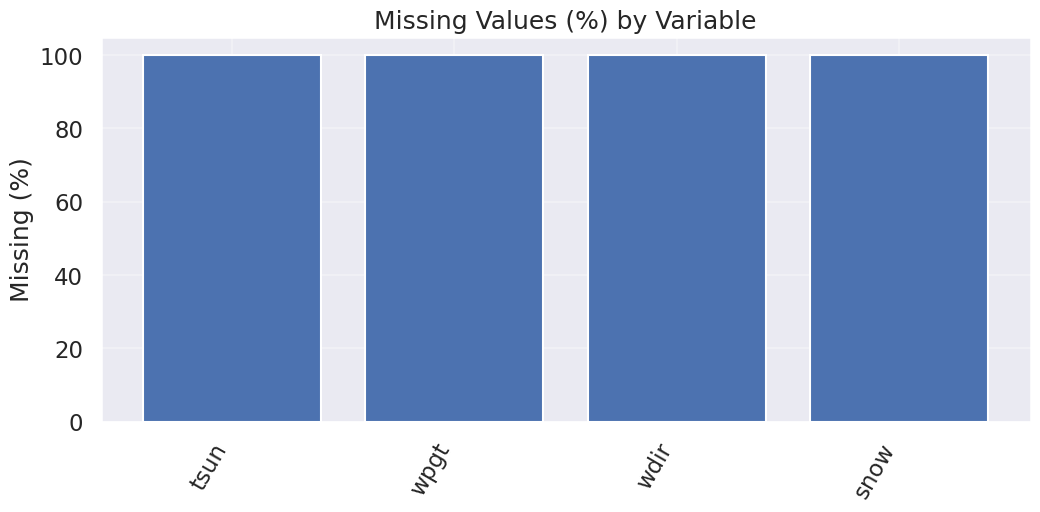

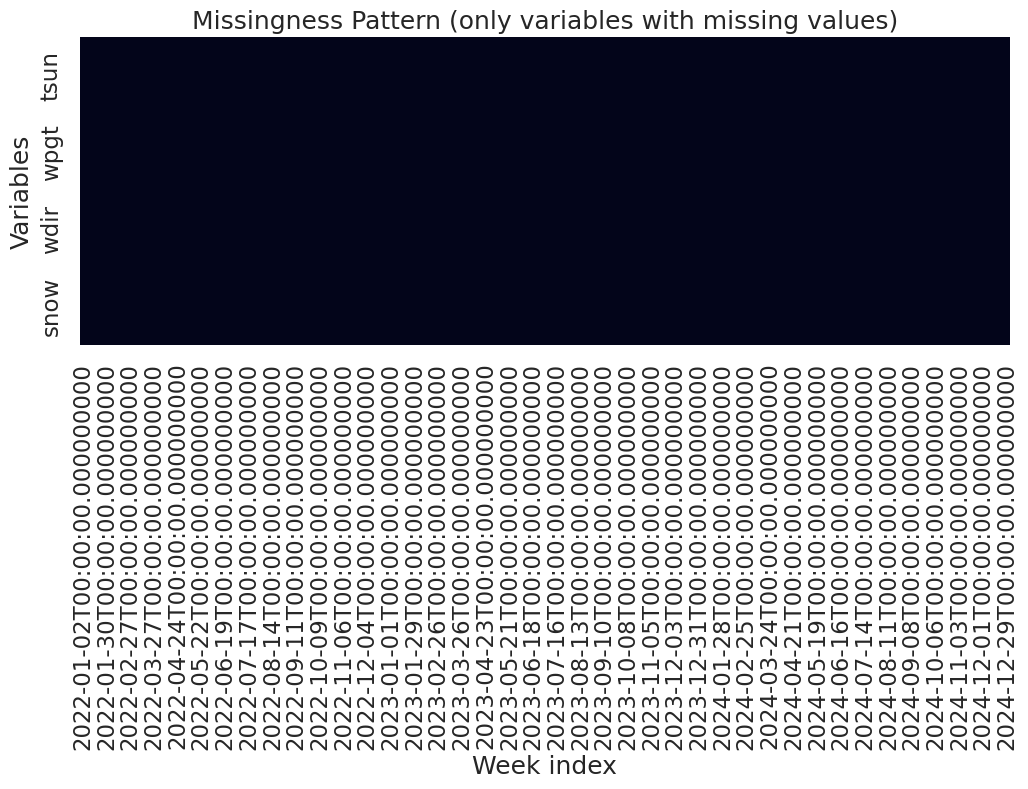

Weather cols: ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'tsun']
Mood cols: ['NegativeMoodIndex', 'PositiveMoodIndex', 'NegativeBehaviorIndex', 'PositiveBehaviorIndex']


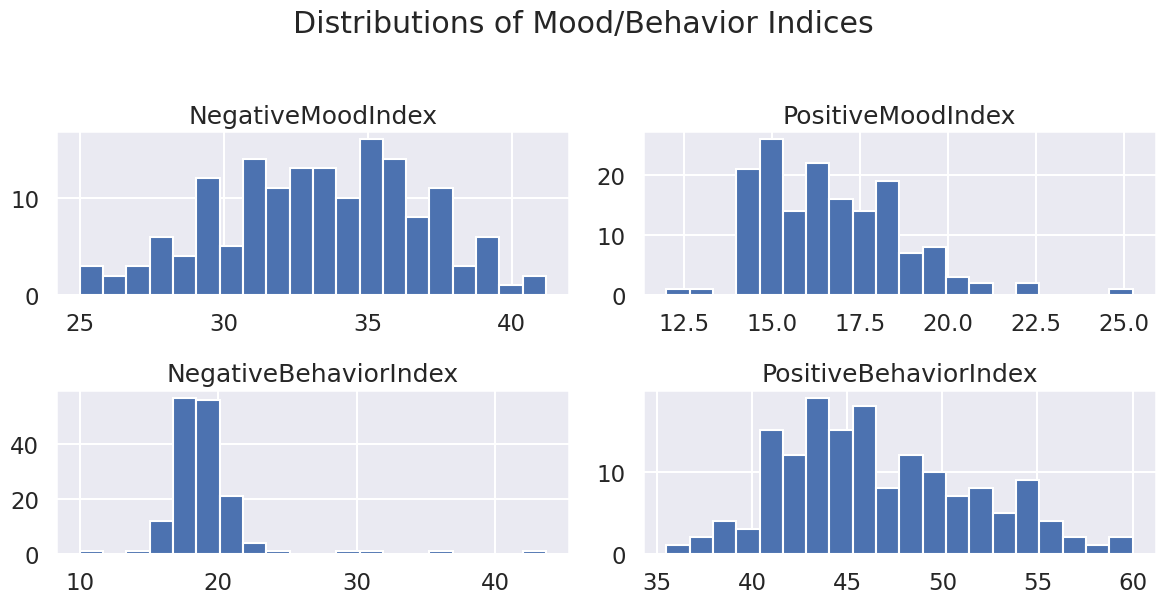

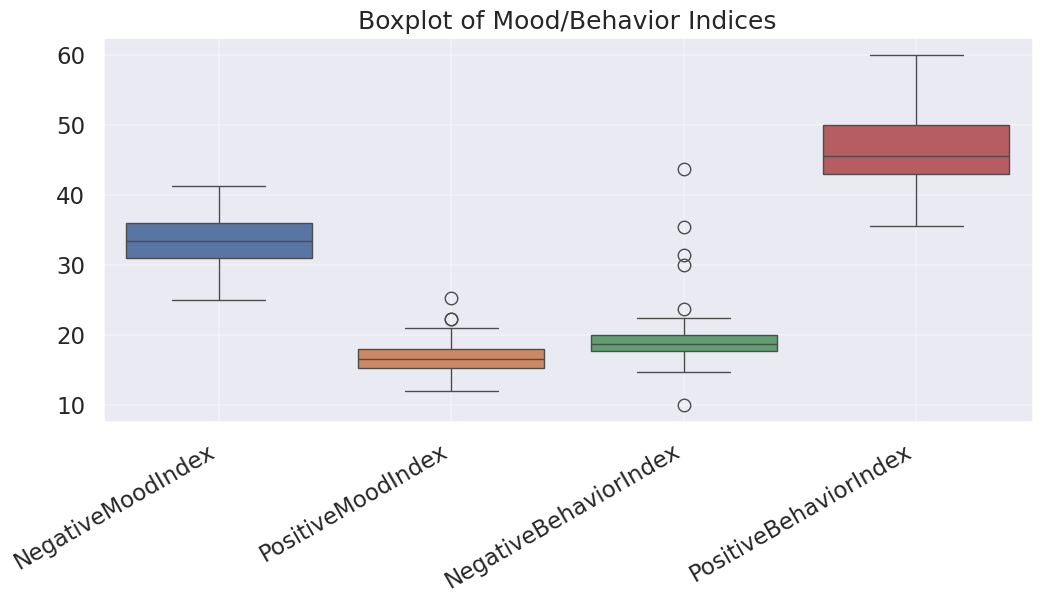

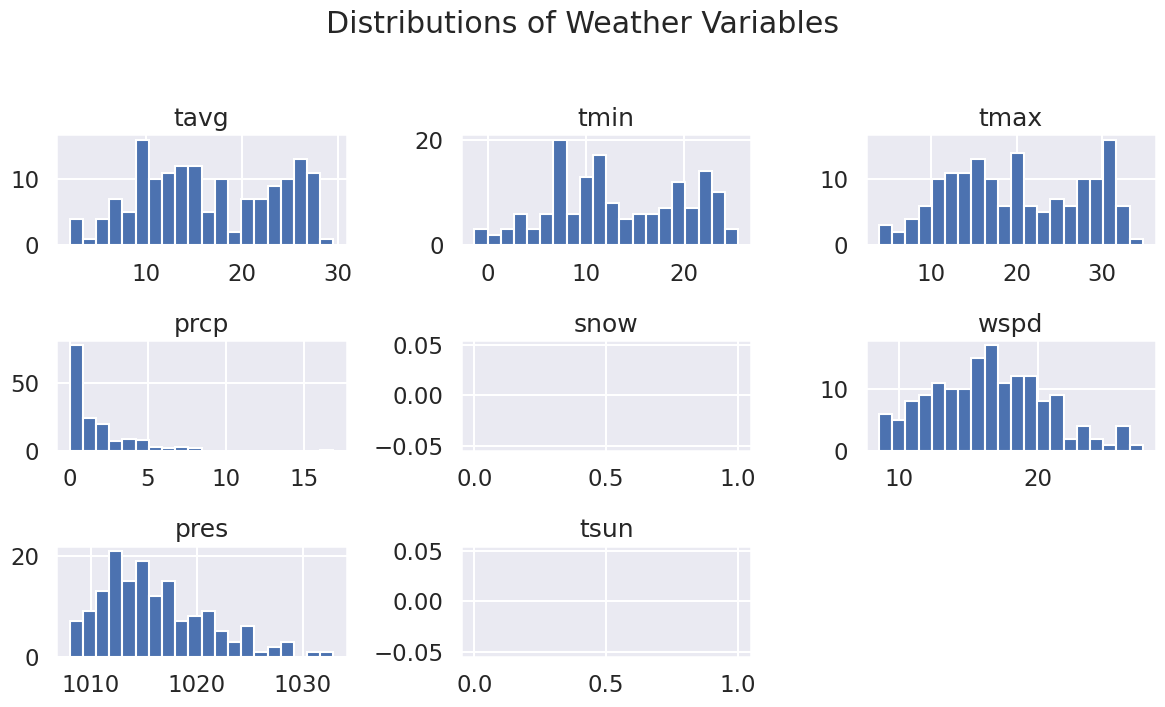

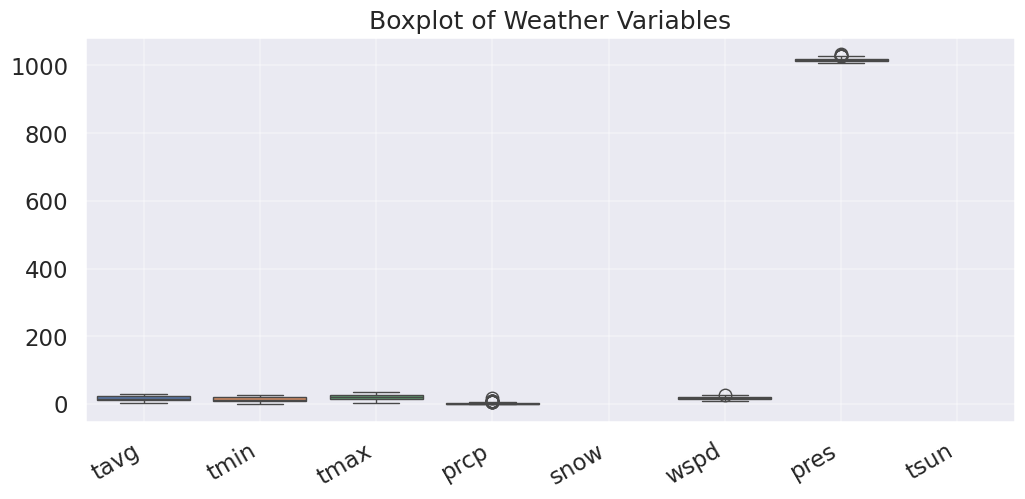

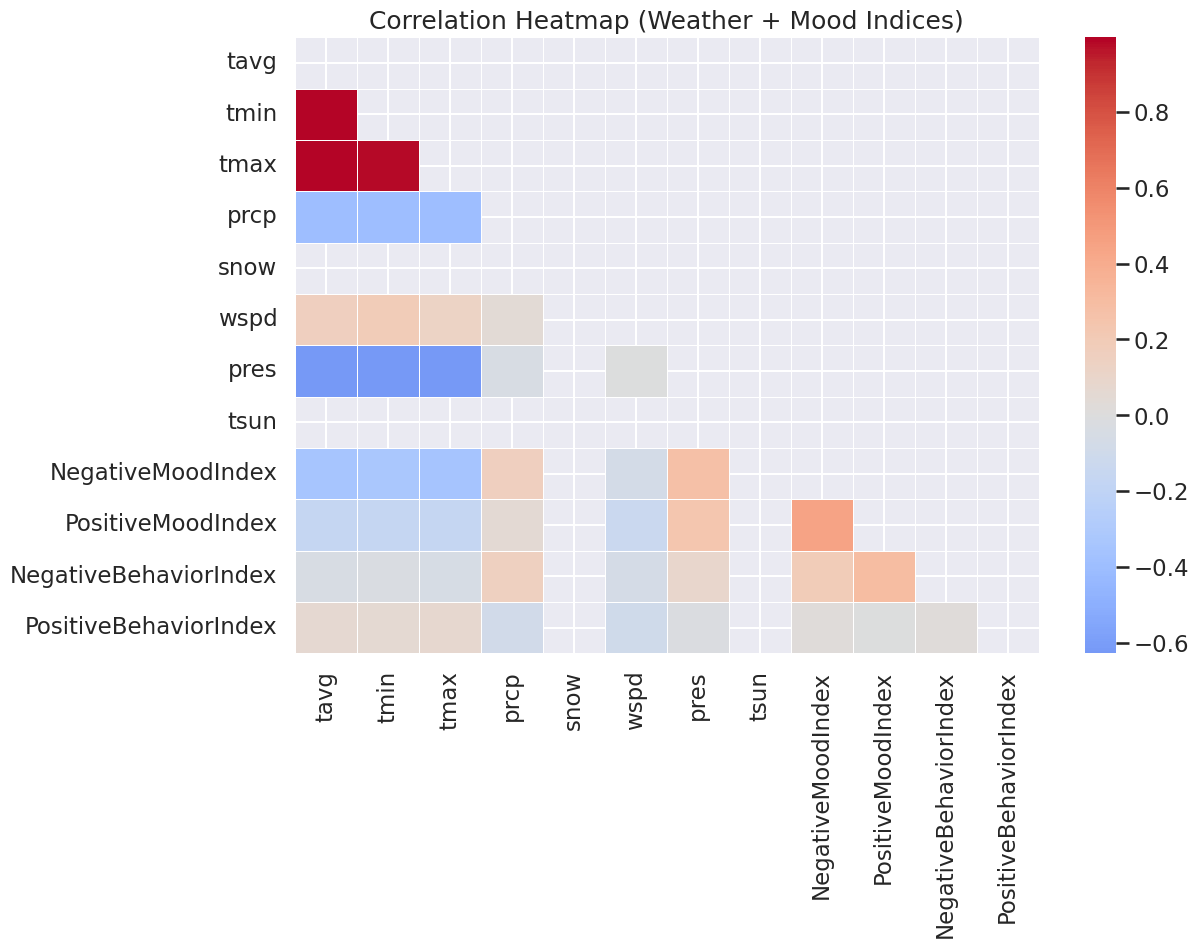

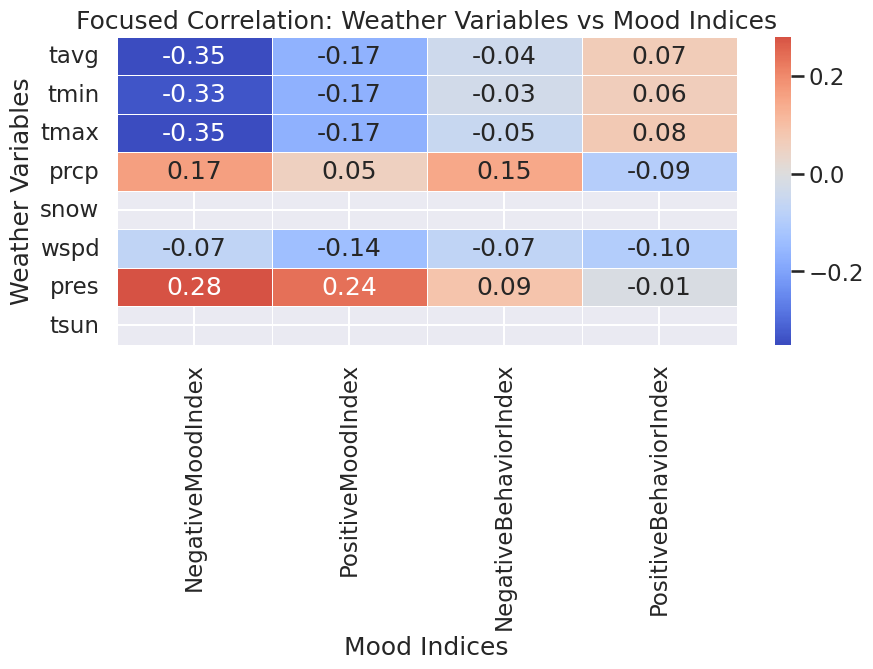

Chosen columns -> temp: tavg | positive: PositiveMoodIndex | negative: NegativeMoodIndex | precip: prcp


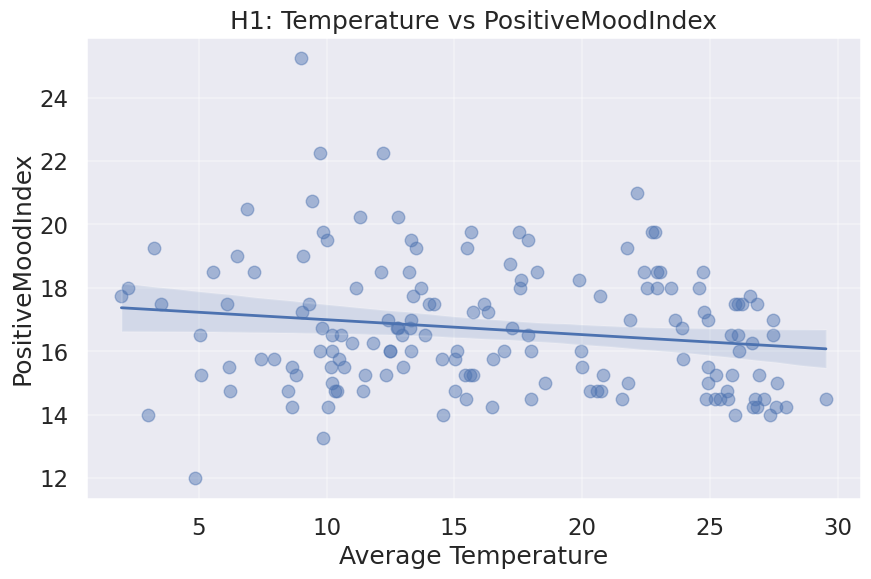

H1 Pearson r = -0.167, p = 0.0368 (n=157)


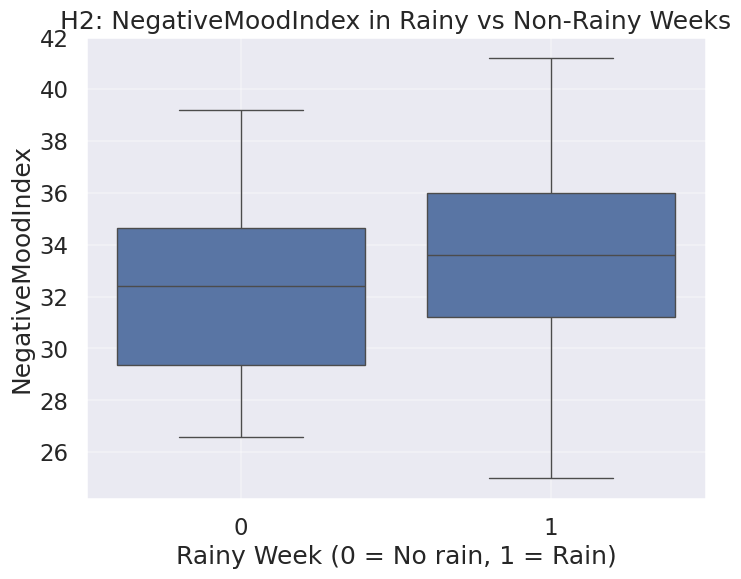

H2 Welch t-test: t = 1.512, p = 0.144 (n0=20, n1=137)


,Hypothesis,Test,r,p_value,n
0,H1,Pearson corr,-0.166782,0.036824,157
1,H2,Welch t-test,NaN,0.143560,157


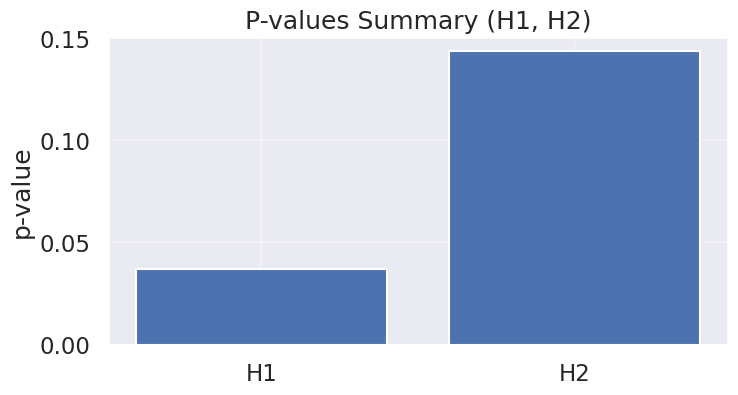

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_context("talk")

df = pd.read_csv("combined_weather_trends_istanbul_TR_2022_2024.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

print("Shape:", df.shape)
display(df.head(3))
display(df.describe().T)

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct_nonzero = missing_pct[missing_pct > 0]

plt.figure(figsize=(12,5))
if len(missing_pct_nonzero) > 0:
    plt.bar(missing_pct_nonzero.index, missing_pct_nonzero.values)
    plt.title("Missing Values (%) by Variable")
    plt.ylabel("Missing (%)")
    plt.xticks(rotation=60, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(12,4))
    sns.heatmap(df[missing_pct_nonzero.index].isna().T, cbar=False)
    plt.title("Missingness Pattern (only variables with missing values)")
    plt.xlabel("Week index")
    plt.ylabel("Variables")
    plt.show()
else:
    plt.bar(["No missing"], [0])
    plt.title("Missing Values (%) by Variable")
    plt.ylabel("Missing (%)")
    plt.grid(alpha=0.3)
    plt.show()
    print("No missing values detected.")

weather_cols = [c for c in df.columns if c.lower() in [
    "tavg","tmin","tmax","precipitation","prcp","snow","wspd","pres","sunshine","clouds"
] or "temp" in c.lower() or "precip" in c.lower() or "sun" in c.lower() or "cloud" in c.lower()]

mood_cols = [c for c in df.columns if "index" in c.lower() or "mood" in c.lower() or "behavior" in c.lower()]

print("Weather cols:", weather_cols)
print("Mood cols:", mood_cols)

if len(mood_cols) > 0:
    df[mood_cols].hist(figsize=(12,6), bins=20)
    plt.suptitle("Distributions of Mood/Behavior Indices", y=1.02)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df[mood_cols])
    plt.title("Boxplot of Mood/Behavior Indices")
    plt.xticks(rotation=30, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

if len(weather_cols) > 0:
    df[weather_cols].hist(figsize=(12,7), bins=20)
    plt.suptitle("Distributions of Weather Variables", y=1.02)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(data=df[weather_cols])
    plt.title("Boxplot of Weather Variables")
    plt.xticks(rotation=30, ha="right")
    plt.grid(alpha=0.3)
    plt.show()

target_cols = [c for c in (weather_cols + mood_cols) if c in df.columns]
if len(target_cols) > 1:
    corr = df[target_cols].corr()
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5)
    plt.title("Correlation Heatmap (Weather + Mood Indices)")
    plt.show()

if len(weather_cols) > 0 and len(mood_cols) > 0:
    corr_focus = df[weather_cols + mood_cols].corr().loc[weather_cols, mood_cols]
    plt.figure(figsize=(10, max(4, 0.35*len(weather_cols))))
    sns.heatmap(corr_focus, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Focused Correlation: Weather Variables vs Mood Indices")
    plt.xlabel("Mood Indices")
    plt.ylabel("Weather Variables")
    plt.show()

temp_col = None
for c in df.columns:
    if c.lower() in ["tavg", "avg_temperature", "temperature", "temp"] or "tavg" in c.lower():
        temp_col = c

pos_col = None
neg_col = None
precip_col = None

for c in df.columns:
    if c.lower() == "positivemoodindex" or "positivemoodindex" in c.lower():
        pos_col = c
    if c.lower() == "negativemoodindex" or "negativemoodindex" in c.lower():
        neg_col = c
    if c.lower() in ["prcp", "precipitation", "precip"] or "precip" in c.lower() or "prcp" in c.lower():
        precip_col = c

print("Chosen columns -> temp:", temp_col, "| positive:", pos_col, "| negative:", neg_col, "| precip:", precip_col)

results = []

if temp_col is not None and pos_col is not None:
    tmp = df[[temp_col, pos_col]].dropna()

    plt.figure(figsize=(10,6))
    sns.regplot(data=tmp, x=temp_col, y=pos_col, scatter_kws={"alpha": 0.45}, line_kws={"linewidth": 2})
    plt.title("H1: Temperature vs PositiveMoodIndex")
    plt.xlabel("Average Temperature")
    plt.ylabel("PositiveMoodIndex")
    plt.grid(alpha=0.3)
    plt.show()

    r, p = stats.pearsonr(tmp[temp_col], tmp[pos_col])
    print(f"H1 Pearson r = {r:.3f}, p = {p:.3g} (n={len(tmp)})")
    results.append({"Hypothesis": "H1", "Test": "Pearson corr", "r": r, "p_value": p, "n": len(tmp)})

if precip_col is not None and neg_col is not None:
    tmp = df[[precip_col, neg_col]].dropna()

    tmp = tmp.copy()
    tmp["RainyWeek"] = (tmp[precip_col] > 0).astype(int)

    plt.figure(figsize=(8,6))
    sns.boxplot(data=tmp, x="RainyWeek", y=neg_col)
    plt.title("H2: NegativeMoodIndex in Rainy vs Non-Rainy Weeks")
    plt.xlabel("Rainy Week (0 = No rain, 1 = Rain)")
    plt.ylabel("NegativeMoodIndex")
    plt.grid(alpha=0.3)
    plt.show()

    group0 = tmp[tmp["RainyWeek"] == 0][neg_col].values
    group1 = tmp[tmp["RainyWeek"] == 1][neg_col].values

    if len(group0) > 1 and len(group1) > 1:
        t_stat, p_val = stats.ttest_ind(group1, group0, equal_var=False)
        print(f"H2 Welch t-test: t = {t_stat:.3f}, p = {p_val:.3g} (n0={len(group0)}, n1={len(group1)})")
        results.append({"Hypothesis": "H2", "Test": "Welch t-test", "r": np.nan, "p_value": p_val, "n": len(tmp)})

if len(results) > 0:
    res_df = pd.DataFrame(results)
    display(res_df)

    plt.figure(figsize=(8,4))
    plt.bar(res_df["Hypothesis"], res_df["p_value"])
    plt.title("P-values Summary (H1, H2)")
    plt.ylabel("p-value")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No hypothesis results computed. Check column names.")


## Additional Statistical Tests

In this section, additional statistical tests are applied to further examine
the proposed hypotheses using different perspectives.

- A **t-test** is used to compare NegativeMoodIndex between rainy and non-rainy weeks.
- A **one-way ANOVA** examines whether PositiveBehaviorIndex differs across
  temperature groups (cold, mild, warm).
- A **chi-square test** evaluates the association between high negative mood
  and rainy conditions.
- Finally, a focused correlation heatmap summarizes relationships between key
  weather variables and mood/behavior indices.


T-test: NegativeMoodIndex (Rainy vs Dry)
t-statistic: 1.5709192368793077
p-value    : 0.12926489000273828
ANOVA: PositiveBehaviorIndex ~ Temperature Group
F-statistic: 0.7096396233619917
p-value    : 0.49342247609803513
Chi-square test: HighNegativeMood vs Rain
Chi2 statistic: 1.091871751137101
p-value       : 0.2960568611714851
Degrees of freedom: 1
Contingency table:
 is_rainy           0   1
HighNegativeMood        
0                 13  68
1                  7  69


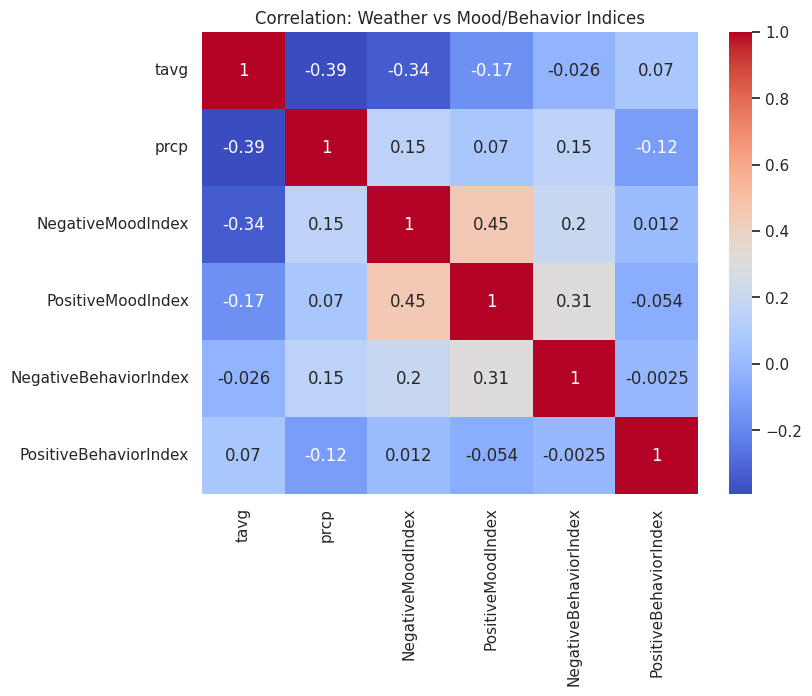

In [ ]:
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency

df = pd.read_csv("combined_weather_trends_istanbul_TR_2022_2024.csv", index_col=0)
df.index = pd.to_datetime(df.index)

df.head()

# rainy vs. dry weeks
df["is_rainy"] = (df["prcp"] > 0).astype(int)

# cold / mild / warm
df["temp_group"] = pd.cut(
    df["tavg"],
    bins=[-50, 10, 20, 50],          # <10, 10-20, >20 degrees
    labels=["cold", "mild", "warm"]
)

# high vs low negative mood relative to median
median_neg_mood = df["NegativeMoodIndex"].median()
df["HighNegativeMood"] = (df["NegativeMoodIndex"] > median_neg_mood).astype(int)

rainy = df[df["is_rainy"] == 1]["NegativeMoodIndex"].dropna()
dry   = df[df["is_rainy"] == 0]["NegativeMoodIndex"].dropna()

t_stat, p_val = stats.ttest_ind(rainy, dry, equal_var=False)

print("T-test: NegativeMoodIndex (Rainy vs Dry)")
print("t-statistic:", t_stat)
print("p-value    :", p_val)

cold = df[df["temp_group"] == "cold"]["PositiveBehaviorIndex"].dropna()
mild = df[df["temp_group"] == "mild"]["PositiveBehaviorIndex"].dropna()
warm = df[df["temp_group"] == "warm"]["PositiveBehaviorIndex"].dropna()

f_stat, p_val = f_oneway(cold, mild, warm)

print("ANOVA: PositiveBehaviorIndex ~ Temperature Group")
print("F-statistic:", f_stat)
print("p-value    :", p_val)

ct = pd.crosstab(df["HighNegativeMood"], df["is_rainy"])

chi2, p_val, dof, expected = chi2_contingency(ct)

print("Chi-square test: HighNegativeMood vs Rain")
print("Chi2 statistic:", chi2)
print("p-value       :", p_val)
print("Degrees of freedom:", dof)
print("Contingency table:\n", ct)

cols_of_interest = [
    "tavg", "prcp",
    "NegativeMoodIndex", "PositiveMoodIndex",
    "NegativeBehaviorIndex", "PositiveBehaviorIndex"
]

corr_subset = df[cols_of_interest].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_subset, annot=True, cmap="coolwarm")
plt.title("Correlation: Weather vs Mood/Behavior Indices")
plt.show()


The statistical tests and correlation analysis indicate that the relationship
between weather conditions and online mood or behavior indices is generally weak.
None of the hypothesis tests yield statistically significant results at the 5%
level, and correlations between weather variables and mood indices remain small
in magnitude.

While moderate correlations are observed between different mood indices
themselves, associations between weather variables (temperature and precipitation)
and mood-related measures appear limited and inconsistent. Overall, the findings
suggest that any weather–mood relationship in this dataset is subtle and not
robustly supported by statistical evidence.
